# GANomaly
- 2020.08.17 : gen 15 / lr 1e-2

# 개발일지
- 2020.08.15 : 분율 추출 구현 / 이상치 상관계수 추출 구현 / 모델 save, load 구현
- 2020.08.16 : anomaly detect 이미지 저장 구현 / 티타늄(Ti64) 상대 밀도 계산 구현

--- 

# Module

In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torchvision.utils import save_image
import os
import numpy as np

import torchvision.datasets as dataset
import torchvision.transforms as transforms
import torchvision.utils as vutils

# Graph & Animation
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Hyper Parameter

In [2]:
latent_size = 100  # z벡터의 잠재공간(latent space)의 크기
workers = 4    # 0일때, 약 20% 사용 4일 경우 메모리 100%
img_size = 64
channel = 1
epochs = 100
batch_size = 64
learning_rate = 1e-2

# Data and Device

In [3]:
# 이미지 경로, 이미지들 리사이즈 및 텐서형태로 만들기
#data_root = "../../dataset/train"
Ti64_aug_data_root = "../../dataset/aug_train/aug_Ti64"

data_set = dataset.ImageFolder(root = Ti64_aug_data_root, # data_root,
                           transform = transforms.Compose([
                                  #transforms.Resize(img_size),
                                  transforms.CenterCrop(img_size),
                                  torchvision.transforms.Grayscale(channel),
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.5,),(0.5,))
                              ]))

print("size of dataset :", len(data_set))

# 배치로 나누고 셔플하기
data_loader = torch.utils.data.DataLoader(data_set, batch_size = batch_size,
                                         shuffle = True, num_workers = workers, drop_last=True)

# Device setting (GPU or CPU)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("device :", device)

size of dataset : 1020
device : cuda:0


# MODEL

In [4]:
# GANomaly : Generative Adversarial Networks Model using Decoder with AutoEncoder

# === Decoder 모델 ===
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder,self).__init__()
        
        # Batch Normalization 유무에 따른 G_block 정의
        def DC_conv_block(in_features, out_features):
            block = [
                    nn.Conv2d(in_features, out_features, 3, 1, 1, bias=False),
                    nn.BatchNorm2d(out_features),
                    nn.ELU()
            ]
            return block
        
        def DC_deconv_block(in_features, out_features, FIRST=True):
            if FIRST:
                block = [
                    nn.ConvTranspose2d(in_features, out_features, 4, 1, 0, bias=False),
                    nn.BatchNorm2d(out_features),
                    nn.ELU()
                ]
            else:
                block = [
                    nn.ConvTranspose2d(in_features, out_features, 4, 2, 1, bias=False),
                    nn.BatchNorm2d(out_features),
                    nn.ELU()
                ]
            return block
        
        
        # ======================= 픽셀 분포 생성 layer ======================= 
        self.DC_gen_distribution = nn.Sequential(
            # ------ input is latent_size 100 ------ 
            *DC_deconv_block(latent_size, img_size*8, FIRST=True),
            # ------ state size is 512x4x4 ------ 
            *DC_conv_block(img_size*8, img_size*8),
            # ------ state size is 512x4x4 ------   
            *DC_deconv_block(img_size*8, img_size*4, FIRST=False),
            # ------ state size is 256x8x8 ------ 
            *DC_conv_block(img_size*4, img_size*4),
            # ------ state size is 256x8x8 ------ 
            *DC_deconv_block(img_size*4, img_size*2, FIRST=False),
            # ------ state size is 128x16x16 ------ 
            *DC_conv_block(img_size*2, img_size*2),
            # ------ state size is 128x16x16 ------ 
            *DC_deconv_block(img_size*2, img_size, FIRST=False),
        )
        
        # =================== 가짜 이미지 생성 layer =================== 
        self.DC_gen_fake_img = nn.Sequential(
            # ------ state size is 64x32x32 ------ 
            nn.ConvTranspose2d(img_size, 1, 4, 2, 1, bias=False),
            nn.Tanh() # 픽셀값의 범위 : -1 ~ 1로 두기 위해서
            # ------ state size is 1x64x64 ------ 
        )
    
    def forward(self, input):
        distribution = self.DC_gen_distribution(input)
        fake_img = self.DC_gen_fake_img(distribution)
        
        return fake_img


# === Discriminator 모델 ===
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        # Batch Normalization 유무에 따른 D_block 정의
        def D_block(in_features, out_features, MP=True):
            if MP:
                block = [
                    nn.Conv2d(in_features, out_features, 3, 1, 1, bias=False),
                    nn.BatchNorm2d(out_features),
                    nn.ELU()
                ]
            else:
                block = [
                    nn.Conv2d(in_features, out_features, 3, 1, 1, bias=False),
                    nn.BatchNorm2d(out_features),
                    nn.ELU(),
                    nn.MaxPool2d(2)
                ]
            return block
        
        # ============== Feature 추출 layer ==============
        self.D_extract_feature = nn.Sequential(
            # ------ input is 1 x 64 x 64 ------ 
            *D_block(channel, img_size, MP=False),
            # ------ input is 64 x 64 x 64 ------ 
            *D_block(img_size, img_size, MP=True),
            # ------ state is 64 x 32 x 32 ------ 
            *D_block(img_size, img_size*2, MP=False),
            # ------ state is 128 x 32 x 32 ------ 
            *D_block(img_size*2, img_size*2, MP=True),
            # ------ state is 128 x 16 x 16 ------ 
            *D_block(img_size*2, img_size*4, MP=False),
            # ------ state is 256 x 16 x 16 ------ 
            *D_block(img_size*4, img_size*4, MP=True),
            # ------ state is 256 x 8 x 8 ------ 
            *D_block(img_size*4, img_size*8, MP=False),
            # ------ state is 512 x 8 x 8 ------ 
            *D_block(img_size*8, img_size*8, MP=True),
        )
        
        # ===================== 이진 분류 layer =====================
        self.D_classification = nn.Sequential(        
            # ------- state size 512x4x4 ------- 
            nn.Conv2d(img_size*8, channel, 4, 1, 0, bias=False),
            #nn.Linear(fms*8*4*4, 1, bias=False),
            nn.Sigmoid()        
        )
        
    def forward(self, input):
        feature = self.D_extract_feature(input)
        classification = self.D_classification(feature)
        
        return classification, feature 


# === Encoder Model ===
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        
        def EC_block(in_features, out_features, MP=True):
            if MP:
                block = [
                    nn.Conv2d(in_features, out_features, 3, 1, 1, bias=False),
                    nn.BatchNorm2d(out_features),
                    nn.ELU()
                ]
            else:
                block = [
                    nn.Conv2d(in_features, out_features, 3, 1, 1, bias=False),
                    nn.BatchNorm2d(out_features),
                    nn.ELU(),
                    nn.MaxPool2d(2)
                ]
            return block
        
        # ============== Feature 추출 ==============
        self.EC_extract_feature = nn.Sequential(
            # ------ input is 1 x 64 x 64 ------ 
            *EC_block(channel, img_size, MP=False),
            # ------ input is 64 x 64 x 64 ------ 
            *EC_block(img_size, img_size, MP=True),
            # ------ state is 64 x 32 x 32 ------ 
            *EC_block(img_size, img_size*2, MP=False),
            # ------ state is 128 x 32 x 32 ------ 
            *EC_block(img_size*2, img_size*2, MP=True),
            # ------ state is 128 x 16 x 16 ------ 
            *EC_block(img_size*2, img_size*4, MP=False),
            # ------ state is 256 x 16 x 16 ------ 
            *EC_block(img_size*4, img_size*4, MP=True),
            # ------ state is 256 x 8 x 8 ------ 
            *EC_block(img_size*4, img_size*8, MP=False),
            # ------ state is 512 x 8 x 8 ------ 
            *EC_block(img_size*8, img_size*8, MP=True),
        )
        
        # =============== Encoder Training layer ===============
        self.EC_validate = nn.Sequential(
            # -------state is 512 x 4 x 4-------
            nn.Conv2d(img_size*8, latent_size, 4, 1, 0, bias=False),
            nn.Tanh()
            # -------state is 100 x 97 x 97-------
        )
        
    def forward(self, input):
        feature = self.EC_extract_feature(input)
        validity = self.EC_validate(feature)
        
        return validity

# Loss & Optim

In [5]:
# DC and D 무게 초기화, classname 에 찾는 name가 없다면 -1 ,
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


# D,DC,EC 네트워크 모델 객체 선언
D = Discriminator().to(device)
DC = Decoder().to(device)
EC = Encoder().to(device)

# weight initialize/ nn.Module 클래스 안에 apply 함수가 정의되 있음, 각 함수들에 다 적용 하게한다
D.apply(weights_init)
DC.apply(weights_init)
EC.apply(weights_init)

# Binary cross entropy loss and optimizer
DCGAN_criterion = nn.BCELoss()
AE_criterion = nn.MSELoss()

# latent vector에 배치 사이즈 64를 적용
# 학습한 DC로 새로운 것 만들어서 결과 확인 할때 사용
noise_z = torch.randn(img_size, latent_size, 1, 1, device = device)

# D와 DC에 대해 두가지 최적화 설정
D_optimizer = torch.optim.Adam(D.parameters(), lr = learning_rate, betas=(0.5,0.999))
DC_optimizer = torch.optim.Adam(DC.parameters(), lr = learning_rate, betas=(0.5,0.999))
EC_optimizer = torch.optim.Adam(EC.parameters(), lr = learning_rate, betas=(0.5,0.999))

#print(D)
#print(DC)
#print(EC)

def reset_grad():
    D_optimizer.zero_grad()
    DC_optimizer.zero_grad()

---

# Train DCGAN

In [6]:
img_list = []
DC_losses = []
D_losses = []
iters = 0

def train_DCGAN(epoch, learning_DC_per_D = 4):
    global epochs
    global iters
    
    # 인덱스 0부터 세기 시작
    # data[0].size():64x1x64x64(image) / data[1].size():64(label)
    for i,data in enumerate(data_loader,0):
        
        # Train D
        real_img = data[0].to(device) # image size: 64x1x64x64(batch, channel, width, height)
        b_size = real_img.size(0) # b_size = 64
        real_labels = torch.ones(b_size, 1).to(device)
        fake_labels = torch.zeros(b_size, 1).to(device)
        
        # (--------------------------real-----------------------------)
        real_classification, _ = D(real_img) # output = D(x)
        real_loss = DCGAN_criterion(real_classification, real_labels) # D(x)=1일 때의 loss
        real_score = real_classification
        D_x = real_score.mean().item() 
            
        # (--------------------------fake-----------------------------)
        z = torch.randn(b_size, latent_size, 1, 1).to(device) # z size :64x100x1x1
        fake_img = DC(z)
        fake_classification, _ = D(fake_img) # output = D(DC(z))
        fake_loss = DCGAN_criterion(fake_classification, fake_labels) # D(DC(z))=0일 때의 loss
        fake_score = fake_classification
        D_DC_z1 = fake_score.mean().item()

        # (------------------Backprop and optimize---------------------)
        D_loss = real_loss + fake_loss
        reset_grad()
        D_loss.backward()
        D_optimizer.step() # D(x)=1, D(DC(z))=0이어야 D가 최적

        
        # Train DC
        #z = torch.randn(b_size,latent_size,1,1,device=device) # z size :64x100x1x1
        for k in range(learning_DC_per_D):
            fake_img = DC(z)
            fake_classification,_ = D(fake_img)  # output : D(DC(z))
            D_DC_z2 = fake_classification.mean().item()
            DC_loss = DCGAN_criterion(fake_classification, real_labels) # D(DC(z))=1일 때의 loss=log(D(DC(z)))

            # (------------------Backprop and optimize---------------------)
            reset_grad()
            DC_loss.backward()
            DC_optimizer.step() # D(DC(z))=1 이어야 DC가 최적
            # ==> D(DC(z))의 값이 0.5로 수렴해야 한다.
        
        
        # print
        print('[%d/%d][%d/%d]\n- D_loss : %.4f / DC_loss : %.4f\n- D(x):%.4f / D(DC(z1)) : %.4f / D(DC(z2)) : %.4f' 
                   %(epoch+1, epochs, i, len(data_loader),D_loss.item(),
                     DC_loss.item(),D_x,D_DC_z1,D_DC_z2))
        
        # Save Losses for plotting later
        DC_losses.append(DC_loss.item())
        D_losses.append(D_loss.item())
        
        #Check how the generator is doing by saving G's output on noise_z
        if (iters % 500 == 0) or ((epoch == epochs-1) and (i == len(data_loader)-1)):
            with torch.no_grad():
                fake = DC(noise_z).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            
        iters += 1
        
#torch.save(E.state_dict(), 'E.ckpt')

In [7]:
for epoch in range(epochs):
    train_DCGAN(epoch, learning_DC_per_D = 15)

/home/piai/anaconda3/envs/pytorch/lib/python3.6/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([64, 1])) that is different to the input size (torch.Size([64, 1, 1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


[1/100][0/15]
- D_loss : 1.3910 / DC_loss : 0.3900
- D(x):0.4992 / D(DC(z1)) : 0.5014 / D(DC(z2)) : 0.6771
[1/100][1/15]
- D_loss : 1.9110 / DC_loss : 0.8453
- D(x):0.4696 / D(DC(z1)) : 0.6774 / D(DC(z2)) : 0.4295
[1/100][2/15]
- D_loss : 1.9393 / DC_loss : 0.4918
- D(x):0.2500 / D(DC(z1)) : 0.4201 / D(DC(z2)) : 0.6115
[1/100][3/15]
- D_loss : 1.5995 / DC_loss : 0.5495
- D(x):0.5069 / D(DC(z1)) : 0.5993 / D(DC(z2)) : 0.5773
[1/100][4/15]
- D_loss : 1.5223 / DC_loss : 0.8311
- D(x):0.5168 / D(DC(z1)) : 0.5755 / D(DC(z2)) : 0.4358
[1/100][5/15]
- D_loss : 1.4124 / DC_loss : 0.7332
- D(x):0.4324 / D(DC(z1)) : 0.4357 / D(DC(z2)) : 0.4803
[1/100][6/15]
- D_loss : 1.4009 / DC_loss : 0.6388
- D(x):0.4702 / D(DC(z1)) : 0.4759 / D(DC(z2)) : 0.5279
[1/100][7/15]
- D_loss : 1.4060 / DC_loss : 0.6508
- D(x):0.5175 / D(DC(z1)) : 0.5263 / D(DC(z2)) : 0.5217
[1/100][8/15]
- D_loss : 1.3928 / DC_loss : 0.6852
- D(x):0.5177 / D(DC(z1)) : 0.5203 / D(DC(z2)) : 0.5040
[1/100][9/15]
- D_loss : 1.3960 / DC_

[6/100][2/15]
- D_loss : 1.3864 / DC_loss : 0.6835
- D(x):0.5005 / D(DC(z1)) : 0.5006 / D(DC(z2)) : 0.5049
[6/100][3/15]
- D_loss : 1.3867 / DC_loss : 0.6896
- D(x):0.5045 / D(DC(z1)) : 0.5046 / D(DC(z2)) : 0.5018
[6/100][4/15]
- D_loss : 1.3867 / DC_loss : 0.7021
- D(x):0.5014 / D(DC(z1)) : 0.5016 / D(DC(z2)) : 0.4955
[6/100][5/15]
- D_loss : 1.3866 / DC_loss : 0.6986
- D(x):0.4952 / D(DC(z1)) : 0.4954 / D(DC(z2)) : 0.4973
[6/100][6/15]
- D_loss : 1.3864 / DC_loss : 0.6900
- D(x):0.4968 / D(DC(z1)) : 0.4969 / D(DC(z2)) : 0.5016
[6/100][7/15]
- D_loss : 1.3869 / DC_loss : 0.6735
- D(x):0.5008 / D(DC(z1)) : 0.5011 / D(DC(z2)) : 0.5099
[6/100][8/15]
- D_loss : 1.3870 / DC_loss : 0.6938
- D(x):0.5093 / D(DC(z1)) : 0.5094 / D(DC(z2)) : 0.4997
[6/100][9/15]
- D_loss : 1.3869 / DC_loss : 0.7041
- D(x):0.4989 / D(DC(z1)) : 0.4992 / D(DC(z2)) : 0.4946
[6/100][10/15]
- D_loss : 1.3868 / DC_loss : 0.7004
- D(x):0.4941 / D(DC(z1)) : 0.4943 / D(DC(z2)) : 0.4964
[6/100][11/15]
- D_loss : 1.3870 / D

[11/100][4/15]
- D_loss : 1.3864 / DC_loss : 0.6915
- D(x):0.5009 / D(DC(z1)) : 0.5010 / D(DC(z2)) : 0.5008
[11/100][5/15]
- D_loss : 1.3864 / DC_loss : 0.6916
- D(x):0.5007 / D(DC(z1)) : 0.5008 / D(DC(z2)) : 0.5008
[11/100][6/15]
- D_loss : 1.3864 / DC_loss : 0.6938
- D(x):0.5006 / D(DC(z1)) : 0.5006 / D(DC(z2)) : 0.4997
[11/100][7/15]
- D_loss : 1.3864 / DC_loss : 0.6960
- D(x):0.4996 / D(DC(z1)) : 0.4996 / D(DC(z2)) : 0.4986
[11/100][8/15]
- D_loss : 1.3864 / DC_loss : 0.6929
- D(x):0.4985 / D(DC(z1)) : 0.4986 / D(DC(z2)) : 0.5001
[11/100][9/15]
- D_loss : 1.3863 / DC_loss : 0.6914
- D(x):0.5001 / D(DC(z1)) : 0.5001 / D(DC(z2)) : 0.5009
[11/100][10/15]
- D_loss : 1.3863 / DC_loss : 0.6942
- D(x):0.5008 / D(DC(z1)) : 0.5008 / D(DC(z2)) : 0.4995
[11/100][11/15]
- D_loss : 1.3865 / DC_loss : 0.6915
- D(x):0.4992 / D(DC(z1)) : 0.4994 / D(DC(z2)) : 0.5008
[11/100][12/15]
- D_loss : 1.3864 / DC_loss : 0.6938
- D(x):0.5007 / D(DC(z1)) : 0.5007 / D(DC(z2)) : 0.4997
[11/100][13/15]
- D_loss 

[16/100][5/15]
- D_loss : 1.3864 / DC_loss : 0.6954
- D(x):0.4993 / D(DC(z1)) : 0.4994 / D(DC(z2)) : 0.4989
[16/100][6/15]
- D_loss : 1.3864 / DC_loss : 0.6944
- D(x):0.4988 / D(DC(z1)) : 0.4989 / D(DC(z2)) : 0.4994
[16/100][7/15]
- D_loss : 1.3864 / DC_loss : 0.6898
- D(x):0.4993 / D(DC(z1)) : 0.4994 / D(DC(z2)) : 0.5017
[16/100][8/15]
- D_loss : 1.3863 / DC_loss : 0.6922
- D(x):0.5016 / D(DC(z1)) : 0.5016 / D(DC(z2)) : 0.5005
[16/100][9/15]
- D_loss : 1.3863 / DC_loss : 0.6932
- D(x):0.5004 / D(DC(z1)) : 0.5005 / D(DC(z2)) : 0.5000
[16/100][10/15]
- D_loss : 1.3863 / DC_loss : 0.6939
- D(x):0.5000 / D(DC(z1)) : 0.5000 / D(DC(z2)) : 0.4996
[16/100][11/15]
- D_loss : 1.3864 / DC_loss : 0.6925
- D(x):0.4996 / D(DC(z1)) : 0.4996 / D(DC(z2)) : 0.5003
[16/100][12/15]
- D_loss : 1.3864 / DC_loss : 0.6945
- D(x):0.5003 / D(DC(z1)) : 0.5003 / D(DC(z2)) : 0.4993
[16/100][13/15]
- D_loss : 1.3863 / DC_loss : 0.6947
- D(x):0.4993 / D(DC(z1)) : 0.4993 / D(DC(z2)) : 0.4992
[16/100][14/15]
- D_loss

[21/100][6/15]
- D_loss : 1.3864 / DC_loss : 0.6948
- D(x):0.5005 / D(DC(z1)) : 0.5006 / D(DC(z2)) : 0.4992
[21/100][7/15]
- D_loss : 1.3864 / DC_loss : 0.6953
- D(x):0.4991 / D(DC(z1)) : 0.4992 / D(DC(z2)) : 0.4989
[21/100][8/15]
- D_loss : 1.3863 / DC_loss : 0.6937
- D(x):0.4989 / D(DC(z1)) : 0.4989 / D(DC(z2)) : 0.4997
[21/100][9/15]
- D_loss : 1.3863 / DC_loss : 0.6920
- D(x):0.4997 / D(DC(z1)) : 0.4997 / D(DC(z2)) : 0.5006
[21/100][10/15]
- D_loss : 1.3864 / DC_loss : 0.6907
- D(x):0.5005 / D(DC(z1)) : 0.5006 / D(DC(z2)) : 0.5012
[21/100][11/15]
- D_loss : 1.3863 / DC_loss : 0.6929
- D(x):0.5012 / D(DC(z1)) : 0.5012 / D(DC(z2)) : 0.5001
[21/100][12/15]
- D_loss : 1.3863 / DC_loss : 0.6941
- D(x):0.5001 / D(DC(z1)) : 0.5001 / D(DC(z2)) : 0.4995
[21/100][13/15]
- D_loss : 1.3863 / DC_loss : 0.6942
- D(x):0.4995 / D(DC(z1)) : 0.4995 / D(DC(z2)) : 0.4994
[21/100][14/15]
- D_loss : 1.3863 / DC_loss : 0.6943
- D(x):0.4994 / D(DC(z1)) : 0.4994 / D(DC(z2)) : 0.4994
[22/100][0/15]
- D_loss

[26/100][7/15]
- D_loss : 1.3863 / DC_loss : 0.6947
- D(x):0.4994 / D(DC(z1)) : 0.4994 / D(DC(z2)) : 0.4992
[26/100][8/15]
- D_loss : 1.3864 / DC_loss : 0.6920
- D(x):0.4991 / D(DC(z1)) : 0.4992 / D(DC(z2)) : 0.5006
[26/100][9/15]
- D_loss : 1.3864 / DC_loss : 0.6888
- D(x):0.5005 / D(DC(z1)) : 0.5006 / D(DC(z2)) : 0.5022
[26/100][10/15]
- D_loss : 1.3864 / DC_loss : 0.6929
- D(x):0.5021 / D(DC(z1)) : 0.5021 / D(DC(z2)) : 0.5001
[26/100][11/15]
- D_loss : 1.3864 / DC_loss : 0.6963
- D(x):0.5001 / D(DC(z1)) : 0.5001 / D(DC(z2)) : 0.4984
[26/100][12/15]
- D_loss : 1.3864 / DC_loss : 0.6952
- D(x):0.4984 / D(DC(z1)) : 0.4984 / D(DC(z2)) : 0.4990
[26/100][13/15]
- D_loss : 1.3863 / DC_loss : 0.6927
- D(x):0.4989 / D(DC(z1)) : 0.4990 / D(DC(z2)) : 0.5002
[26/100][14/15]
- D_loss : 1.3863 / DC_loss : 0.6908
- D(x):0.5002 / D(DC(z1)) : 0.5002 / D(DC(z2)) : 0.5012
[27/100][0/15]
- D_loss : 1.3864 / DC_loss : 0.6895
- D(x):0.5011 / D(DC(z1)) : 0.5011 / D(DC(z2)) : 0.5018
[27/100][1/15]
- D_loss

[31/100][8/15]
- D_loss : 1.3864 / DC_loss : 0.6919
- D(x):0.5003 / D(DC(z1)) : 0.5003 / D(DC(z2)) : 0.5006
[31/100][9/15]
- D_loss : 1.3863 / DC_loss : 0.6921
- D(x):0.5006 / D(DC(z1)) : 0.5006 / D(DC(z2)) : 0.5005
[31/100][10/15]
- D_loss : 1.3864 / DC_loss : 0.6915
- D(x):0.5004 / D(DC(z1)) : 0.5005 / D(DC(z2)) : 0.5008
[31/100][11/15]
- D_loss : 1.3864 / DC_loss : 0.6934
- D(x):0.5008 / D(DC(z1)) : 0.5008 / D(DC(z2)) : 0.4999
[31/100][12/15]
- D_loss : 1.3864 / DC_loss : 0.6942
- D(x):0.4998 / D(DC(z1)) : 0.4999 / D(DC(z2)) : 0.4995
[31/100][13/15]
- D_loss : 1.3864 / DC_loss : 0.6933
- D(x):0.4995 / D(DC(z1)) : 0.4995 / D(DC(z2)) : 0.4999
[31/100][14/15]
- D_loss : 1.3863 / DC_loss : 0.6939
- D(x):0.4999 / D(DC(z1)) : 0.4999 / D(DC(z2)) : 0.4996
[32/100][0/15]
- D_loss : 1.3863 / DC_loss : 0.6930
- D(x):0.4996 / D(DC(z1)) : 0.4996 / D(DC(z2)) : 0.5001
[32/100][1/15]
- D_loss : 1.3863 / DC_loss : 0.6926
- D(x):0.5000 / D(DC(z1)) : 0.5001 / D(DC(z2)) : 0.5003
[32/100][2/15]
- D_loss

[36/100][9/15]
- D_loss : 1.3863 / DC_loss : 0.6941
- D(x):0.4998 / D(DC(z1)) : 0.4998 / D(DC(z2)) : 0.4995
[36/100][10/15]
- D_loss : 1.3863 / DC_loss : 0.6937
- D(x):0.4995 / D(DC(z1)) : 0.4995 / D(DC(z2)) : 0.4997
[36/100][11/15]
- D_loss : 1.3863 / DC_loss : 0.6930
- D(x):0.4997 / D(DC(z1)) : 0.4997 / D(DC(z2)) : 0.5000
[36/100][12/15]
- D_loss : 1.3863 / DC_loss : 0.6931
- D(x):0.5000 / D(DC(z1)) : 0.5000 / D(DC(z2)) : 0.5000
[36/100][13/15]
- D_loss : 1.3863 / DC_loss : 0.6921
- D(x):0.5000 / D(DC(z1)) : 0.5000 / D(DC(z2)) : 0.5005
[36/100][14/15]
- D_loss : 1.3863 / DC_loss : 0.6922
- D(x):0.5005 / D(DC(z1)) : 0.5005 / D(DC(z2)) : 0.5005
[37/100][0/15]
- D_loss : 1.3863 / DC_loss : 0.6930
- D(x):0.5005 / D(DC(z1)) : 0.5005 / D(DC(z2)) : 0.5001
[37/100][1/15]
- D_loss : 1.3863 / DC_loss : 0.6940
- D(x):0.5000 / D(DC(z1)) : 0.5000 / D(DC(z2)) : 0.4996
[37/100][2/15]
- D_loss : 1.3863 / DC_loss : 0.6932
- D(x):0.4996 / D(DC(z1)) : 0.4996 / D(DC(z2)) : 0.5000
[37/100][3/15]
- D_loss

[41/100][10/15]
- D_loss : 1.3863 / DC_loss : 0.6928
- D(x):0.5005 / D(DC(z1)) : 0.5006 / D(DC(z2)) : 0.5002
[41/100][11/15]
- D_loss : 1.3863 / DC_loss : 0.6939
- D(x):0.5002 / D(DC(z1)) : 0.5002 / D(DC(z2)) : 0.4996
[41/100][12/15]
- D_loss : 1.3863 / DC_loss : 0.6935
- D(x):0.4996 / D(DC(z1)) : 0.4996 / D(DC(z2)) : 0.4998
[41/100][13/15]
- D_loss : 1.3863 / DC_loss : 0.6929
- D(x):0.4998 / D(DC(z1)) : 0.4998 / D(DC(z2)) : 0.5001
[41/100][14/15]
- D_loss : 1.3863 / DC_loss : 0.6924
- D(x):0.5001 / D(DC(z1)) : 0.5001 / D(DC(z2)) : 0.5004
[42/100][0/15]
- D_loss : 1.3863 / DC_loss : 0.6932
- D(x):0.5003 / D(DC(z1)) : 0.5004 / D(DC(z2)) : 0.5000
[42/100][1/15]
- D_loss : 1.3863 / DC_loss : 0.6934
- D(x):0.5000 / D(DC(z1)) : 0.5000 / D(DC(z2)) : 0.4999
[42/100][2/15]
- D_loss : 1.3863 / DC_loss : 0.6934
- D(x):0.4999 / D(DC(z1)) : 0.4999 / D(DC(z2)) : 0.4999
[42/100][3/15]
- D_loss : 1.3863 / DC_loss : 0.6931
- D(x):0.4999 / D(DC(z1)) : 0.4999 / D(DC(z2)) : 0.5000
[42/100][4/15]
- D_loss

[46/100][11/15]
- D_loss : 1.3863 / DC_loss : 0.6933
- D(x):0.4996 / D(DC(z1)) : 0.4996 / D(DC(z2)) : 0.4999
[46/100][12/15]
- D_loss : 1.3863 / DC_loss : 0.6932
- D(x):0.4999 / D(DC(z1)) : 0.4999 / D(DC(z2)) : 0.5000
[46/100][13/15]
- D_loss : 1.3863 / DC_loss : 0.6929
- D(x):0.4999 / D(DC(z1)) : 0.5000 / D(DC(z2)) : 0.5001
[46/100][14/15]
- D_loss : 1.3863 / DC_loss : 0.6928
- D(x):0.5001 / D(DC(z1)) : 0.5001 / D(DC(z2)) : 0.5002
[47/100][0/15]
- D_loss : 1.3863 / DC_loss : 0.6950
- D(x):0.5002 / D(DC(z1)) : 0.5002 / D(DC(z2)) : 0.4991
[47/100][1/15]
- D_loss : 1.3863 / DC_loss : 0.6924
- D(x):0.4991 / D(DC(z1)) : 0.4991 / D(DC(z2)) : 0.5004
[47/100][2/15]
- D_loss : 1.3863 / DC_loss : 0.6921
- D(x):0.5004 / D(DC(z1)) : 0.5004 / D(DC(z2)) : 0.5005
[47/100][3/15]
- D_loss : 1.3863 / DC_loss : 0.6937
- D(x):0.5005 / D(DC(z1)) : 0.5005 / D(DC(z2)) : 0.4997
[47/100][4/15]
- D_loss : 1.3863 / DC_loss : 0.6936
- D(x):0.4997 / D(DC(z1)) : 0.4997 / D(DC(z2)) : 0.4998
[47/100][5/15]
- D_loss 

[51/100][12/15]
- D_loss : 1.3863 / DC_loss : 0.6931
- D(x):0.5005 / D(DC(z1)) : 0.5005 / D(DC(z2)) : 0.5000
[51/100][13/15]
- D_loss : 1.3863 / DC_loss : 0.6943
- D(x):0.5000 / D(DC(z1)) : 0.5000 / D(DC(z2)) : 0.4994
[51/100][14/15]
- D_loss : 1.3863 / DC_loss : 0.6935
- D(x):0.4994 / D(DC(z1)) : 0.4994 / D(DC(z2)) : 0.4998
[52/100][0/15]
- D_loss : 1.3863 / DC_loss : 0.6924
- D(x):0.4998 / D(DC(z1)) : 0.4998 / D(DC(z2)) : 0.5004
[52/100][1/15]
- D_loss : 1.3863 / DC_loss : 0.6928
- D(x):0.5004 / D(DC(z1)) : 0.5004 / D(DC(z2)) : 0.5002
[52/100][2/15]
- D_loss : 1.3863 / DC_loss : 0.6932
- D(x):0.5002 / D(DC(z1)) : 0.5002 / D(DC(z2)) : 0.5000
[52/100][3/15]
- D_loss : 1.3863 / DC_loss : 0.6926
- D(x):0.5000 / D(DC(z1)) : 0.5000 / D(DC(z2)) : 0.5003
[52/100][4/15]
- D_loss : 1.3863 / DC_loss : 0.6930
- D(x):0.5003 / D(DC(z1)) : 0.5003 / D(DC(z2)) : 0.5001
[52/100][5/15]
- D_loss : 1.3863 / DC_loss : 0.6935
- D(x):0.5001 / D(DC(z1)) : 0.5001 / D(DC(z2)) : 0.4998
[52/100][6/15]
- D_loss :

[56/100][13/15]
- D_loss : 1.3888 / DC_loss : 0.6841
- D(x):0.4994 / D(DC(z1)) : 0.5007 / D(DC(z2)) : 0.5045
[56/100][14/15]
- D_loss : 1.3869 / DC_loss : 0.7041
- D(x):0.5042 / D(DC(z1)) : 0.5044 / D(DC(z2)) : 0.4946
[57/100][0/15]
- D_loss : 1.3866 / DC_loss : 0.6917
- D(x):0.4943 / D(DC(z1)) : 0.4944 / D(DC(z2)) : 0.5007
[57/100][1/15]
- D_loss : 1.3854 / DC_loss : 0.6927
- D(x):0.5008 / D(DC(z1)) : 0.5004 / D(DC(z2)) : 0.5002
[57/100][2/15]
- D_loss : 1.3859 / DC_loss : 0.6939
- D(x):0.5003 / D(DC(z1)) : 0.5001 / D(DC(z2)) : 0.4996
[57/100][3/15]
- D_loss : 1.3836 / DC_loss : 0.6866
- D(x):0.5009 / D(DC(z1)) : 0.4996 / D(DC(z2)) : 0.5033
[57/100][4/15]
- D_loss : 1.3939 / DC_loss : 0.8533
- D(x):0.4995 / D(DC(z1)) : 0.5033 / D(DC(z2)) : 0.4260
[57/100][5/15]
- D_loss : 1.2944 / DC_loss : 0.0040
- D(x):0.4775 / D(DC(z1)) : 0.4260 / D(DC(z2)) : 0.9960
[57/100][6/15]
- D_loss : 5.6782 / DC_loss : 0.0000
- D(x):0.8780 / D(DC(z1)) : 0.9960 / D(DC(z2)) : 1.0000
[57/100][7/15]
- D_loss : 

[61/100][14/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[62/100][0/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[62/100][1/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[62/100][2/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[62/100][3/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[62/100][4/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[62/100][5/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[62/100][6/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[62/100][7/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[62/100][8/15]
- D

[66/100][14/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[67/100][0/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[67/100][1/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[67/100][2/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[67/100][3/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[67/100][4/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[67/100][5/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[67/100][6/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[67/100][7/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[67/100][8/15]
- D

[71/100][14/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[72/100][0/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[72/100][1/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[72/100][2/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[72/100][3/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[72/100][4/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[72/100][5/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[72/100][6/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[72/100][7/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[72/100][8/15]
- D

[76/100][14/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[77/100][0/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[77/100][1/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[77/100][2/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[77/100][3/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[77/100][4/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[77/100][5/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[77/100][6/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[77/100][7/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[77/100][8/15]
- D

[81/100][14/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[82/100][0/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[82/100][1/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[82/100][2/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[82/100][3/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[82/100][4/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[82/100][5/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[82/100][6/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[82/100][7/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[82/100][8/15]
- D

[86/100][14/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[87/100][0/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[87/100][1/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[87/100][2/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[87/100][3/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[87/100][4/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[87/100][5/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[87/100][6/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[87/100][7/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[87/100][8/15]
- D

[91/100][14/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[92/100][0/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[92/100][1/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[92/100][2/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[92/100][3/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[92/100][4/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[92/100][5/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[92/100][6/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[92/100][7/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[92/100][8/15]
- D

[96/100][14/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[97/100][0/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[97/100][1/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[97/100][2/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[97/100][3/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[97/100][4/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[97/100][5/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[97/100][6/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[97/100][7/15]
- D_loss : 27.6310 / DC_loss : 0.0000
- D(x):1.0000 / D(DC(z1)) : 1.0000 / D(DC(z2)) : 1.0000
[97/100][8/15]
- D

# Animation

In [8]:
def animate_gen_imgs():
    fig = plt.figure(figsize=(8,8))
    plt.axis("off")
    
    ims=[[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
    ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
    HTML(ani.to_jshtml())

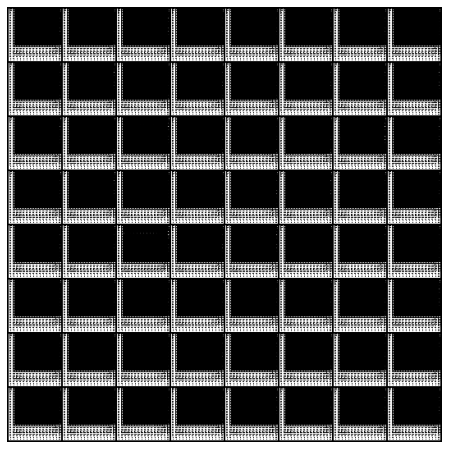

In [9]:
animate_gen_imgs()

# Trian : izif E

In [10]:
DC.eval()
D.eval()

kappa = 1.0
EC_losses = []

iters = 0
AE_img_list = []

def train_AE(epoch):
    global epochs
    global iters
    global EC_losses
    global AE_img_list
    
    # 인덱스 0부터 세기 시작
    # data[0].size():64x1x64x64(image) / data[1].size():64(label)
    for i,data in enumerate(data_loader,0):
        
        real_imgs = data[0].to(device)
        
        EC_optimizer.zero_grad()
        
        EC_validity = EC(real_imgs)
        
        fake_imgs = DC(EC_validity)
        
        _, real_features = D.forward(real_imgs)
        _, fake_features = D.forward(fake_imgs)
        
        
        # izif architecture
        imgs_loss = AE_criterion(real_imgs, fake_imgs)
        features_loss = AE_criterion(real_features, fake_features)
        EC_loss = imgs_loss + kappa*features_loss
        
        EC_loss.backward()
        EC_optimizer.step()
        
        # =============================================================
        # print
        # =============================================================
        print('[%d/%d][%d/%d]\n- E_loss: %.4f\n'
              %(epoch+1, epochs, i, len(data_loader), EC_loss.item()))
        
        # Save Losses for plotting later
        EC_losses.append(EC_loss.item())
        
        #Check how the generator is doing by saving G's output on noise_z
        if (iters % 500 == 0) or ((epoch == epochs-1) and (i == len(data_loader)-1)):
            with torch.no_grad():
                fake = DC(EC_validity).detach().cpu()
            AE_img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            
        iters += 1
        
#torch.save(E.state_dict(), 'E.ckpt')

In [11]:
for epoch in range(epochs):
    train_AE(epoch)

[1/100][0/15]
- E_loss: 1.3926

[1/100][1/15]
- E_loss: 1.4133

[1/100][2/15]
- E_loss: 1.4780

[1/100][3/15]
- E_loss: 1.4594

[1/100][4/15]
- E_loss: 1.4232

[1/100][5/15]
- E_loss: 1.3890

[1/100][6/15]
- E_loss: 1.3689

[1/100][7/15]
- E_loss: 1.3579

[1/100][8/15]
- E_loss: 1.3812

[1/100][9/15]
- E_loss: 1.4312

[1/100][10/15]
- E_loss: 1.3566

[1/100][11/15]
- E_loss: 1.3783

[1/100][12/15]
- E_loss: 1.3522

[1/100][13/15]
- E_loss: 1.4070

[1/100][14/15]
- E_loss: 1.4355

[2/100][0/15]
- E_loss: 1.4008

[2/100][1/15]
- E_loss: 1.4586

[2/100][2/15]
- E_loss: 1.4230

[2/100][3/15]
- E_loss: 1.3251

[2/100][4/15]
- E_loss: 1.3577

[2/100][5/15]
- E_loss: 1.3551

[2/100][6/15]
- E_loss: 1.3407

[2/100][7/15]
- E_loss: 1.4311

[2/100][8/15]
- E_loss: 1.3810

[2/100][9/15]
- E_loss: 1.3900

[2/100][10/15]
- E_loss: 1.4148

[2/100][11/15]
- E_loss: 1.4716

[2/100][12/15]
- E_loss: 1.4374

[2/100][13/15]
- E_loss: 1.4028

[2/100][14/15]
- E_loss: 1.3997

[3/100][0/15]
- E_loss: 1.3670

[17/100][12/15]
- E_loss: 1.4100

[17/100][13/15]
- E_loss: 1.3356

[17/100][14/15]
- E_loss: 1.4096

[18/100][0/15]
- E_loss: 1.4320

[18/100][1/15]
- E_loss: 1.3686

[18/100][2/15]
- E_loss: 1.3498

[18/100][3/15]
- E_loss: 1.3796

[18/100][4/15]
- E_loss: 1.3725

[18/100][5/15]
- E_loss: 1.4109

[18/100][6/15]
- E_loss: 1.4204

[18/100][7/15]
- E_loss: 1.5193

[18/100][8/15]
- E_loss: 1.4051

[18/100][9/15]
- E_loss: 1.3497

[18/100][10/15]
- E_loss: 1.4397

[18/100][11/15]
- E_loss: 1.3766

[18/100][12/15]
- E_loss: 1.3426

[18/100][13/15]
- E_loss: 1.4146

[18/100][14/15]
- E_loss: 1.3813

[19/100][0/15]
- E_loss: 1.4028

[19/100][1/15]
- E_loss: 1.4081

[19/100][2/15]
- E_loss: 1.3794

[19/100][3/15]
- E_loss: 1.3635

[19/100][4/15]
- E_loss: 1.3920

[19/100][5/15]
- E_loss: 1.4299

[19/100][6/15]
- E_loss: 1.4025

[19/100][7/15]
- E_loss: 1.3862

[19/100][8/15]
- E_loss: 1.3961

[19/100][9/15]
- E_loss: 1.3186

[19/100][10/15]
- E_loss: 1.4587

[19/100][11/15]
- E_loss: 1.3954



[34/100][3/15]
- E_loss: 1.3682

[34/100][4/15]
- E_loss: 1.3825

[34/100][5/15]
- E_loss: 1.3718

[34/100][6/15]
- E_loss: 1.5242

[34/100][7/15]
- E_loss: 1.4444

[34/100][8/15]
- E_loss: 1.3763

[34/100][9/15]
- E_loss: 1.3976

[34/100][10/15]
- E_loss: 1.4510

[34/100][11/15]
- E_loss: 1.4298

[34/100][12/15]
- E_loss: 1.3975

[34/100][13/15]
- E_loss: 1.3393

[34/100][14/15]
- E_loss: 1.4287

[35/100][0/15]
- E_loss: 1.3712

[35/100][1/15]
- E_loss: 1.4202

[35/100][2/15]
- E_loss: 1.2885

[35/100][3/15]
- E_loss: 1.3920

[35/100][4/15]
- E_loss: 1.4114

[35/100][5/15]
- E_loss: 1.4295

[35/100][6/15]
- E_loss: 1.4249

[35/100][7/15]
- E_loss: 1.3662

[35/100][8/15]
- E_loss: 1.3870

[35/100][9/15]
- E_loss: 1.4328

[35/100][10/15]
- E_loss: 1.3296

[35/100][11/15]
- E_loss: 1.4161

[35/100][12/15]
- E_loss: 1.5218

[35/100][13/15]
- E_loss: 1.3999

[35/100][14/15]
- E_loss: 1.3773

[36/100][0/15]
- E_loss: 1.4113

[36/100][1/15]
- E_loss: 1.4333

[36/100][2/15]
- E_loss: 1.3981



[50/100][9/15]
- E_loss: 1.3849

[50/100][10/15]
- E_loss: 1.3798

[50/100][11/15]
- E_loss: 1.3429

[50/100][12/15]
- E_loss: 1.4116

[50/100][13/15]
- E_loss: 1.3705

[50/100][14/15]
- E_loss: 1.4160

[51/100][0/15]
- E_loss: 1.4099

[51/100][1/15]
- E_loss: 1.3730

[51/100][2/15]
- E_loss: 1.4017

[51/100][3/15]
- E_loss: 1.4271

[51/100][4/15]
- E_loss: 1.4466

[51/100][5/15]
- E_loss: 1.4583

[51/100][6/15]
- E_loss: 1.4065

[51/100][7/15]
- E_loss: 1.4008

[51/100][8/15]
- E_loss: 1.4202

[51/100][9/15]
- E_loss: 1.3655

[51/100][10/15]
- E_loss: 1.3526

[51/100][11/15]
- E_loss: 1.3659

[51/100][12/15]
- E_loss: 1.3883

[51/100][13/15]
- E_loss: 1.4166

[51/100][14/15]
- E_loss: 1.3494

[52/100][0/15]
- E_loss: 1.4375

[52/100][1/15]
- E_loss: 1.4212

[52/100][2/15]
- E_loss: 1.4178

[52/100][3/15]
- E_loss: 1.4752

[52/100][4/15]
- E_loss: 1.4358

[52/100][5/15]
- E_loss: 1.4310

[52/100][6/15]
- E_loss: 1.4092

[52/100][7/15]
- E_loss: 1.3312

[52/100][8/15]
- E_loss: 1.3765



[67/100][0/15]
- E_loss: 1.4222

[67/100][1/15]
- E_loss: 1.4091

[67/100][2/15]
- E_loss: 1.4592

[67/100][3/15]
- E_loss: 1.3644

[67/100][4/15]
- E_loss: 1.3104

[67/100][5/15]
- E_loss: 1.4184

[67/100][6/15]
- E_loss: 1.3973

[67/100][7/15]
- E_loss: 1.4283

[67/100][8/15]
- E_loss: 1.3958

[67/100][9/15]
- E_loss: 1.4400

[67/100][10/15]
- E_loss: 1.3991

[67/100][11/15]
- E_loss: 1.3865

[67/100][12/15]
- E_loss: 1.3538

[67/100][13/15]
- E_loss: 1.4360

[67/100][14/15]
- E_loss: 1.3671

[68/100][0/15]
- E_loss: 1.4116

[68/100][1/15]
- E_loss: 1.3978

[68/100][2/15]
- E_loss: 1.4001

[68/100][3/15]
- E_loss: 1.3799

[68/100][4/15]
- E_loss: 1.4160

[68/100][5/15]
- E_loss: 1.4207

[68/100][6/15]
- E_loss: 1.3575

[68/100][7/15]
- E_loss: 1.4092

[68/100][8/15]
- E_loss: 1.4198

[68/100][9/15]
- E_loss: 1.4003

[68/100][10/15]
- E_loss: 1.4220

[68/100][11/15]
- E_loss: 1.4123

[68/100][12/15]
- E_loss: 1.3824

[68/100][13/15]
- E_loss: 1.3962

[68/100][14/15]
- E_loss: 1.4143



[83/100][6/15]
- E_loss: 1.3296

[83/100][7/15]
- E_loss: 1.4601

[83/100][8/15]
- E_loss: 1.3797

[83/100][9/15]
- E_loss: 1.4440

[83/100][10/15]
- E_loss: 1.3684

[83/100][11/15]
- E_loss: 1.4185

[83/100][12/15]
- E_loss: 1.3935

[83/100][13/15]
- E_loss: 1.4243

[83/100][14/15]
- E_loss: 1.3572

[84/100][0/15]
- E_loss: 1.3501

[84/100][1/15]
- E_loss: 1.4205

[84/100][2/15]
- E_loss: 1.4954

[84/100][3/15]
- E_loss: 1.3619

[84/100][4/15]
- E_loss: 1.3993

[84/100][5/15]
- E_loss: 1.4634

[84/100][6/15]
- E_loss: 1.4019

[84/100][7/15]
- E_loss: 1.3957

[84/100][8/15]
- E_loss: 1.3944

[84/100][9/15]
- E_loss: 1.3636

[84/100][10/15]
- E_loss: 1.3700

[84/100][11/15]
- E_loss: 1.3859

[84/100][12/15]
- E_loss: 1.4177

[84/100][13/15]
- E_loss: 1.4078

[84/100][14/15]
- E_loss: 1.3535

[85/100][0/15]
- E_loss: 1.3904

[85/100][1/15]
- E_loss: 1.3897

[85/100][2/15]
- E_loss: 1.3816

[85/100][3/15]
- E_loss: 1.3732

[85/100][4/15]
- E_loss: 1.3417

[85/100][5/15]
- E_loss: 1.3645



[99/100][12/15]
- E_loss: 1.4694

[99/100][13/15]
- E_loss: 1.4635

[99/100][14/15]
- E_loss: 1.4145

[100/100][0/15]
- E_loss: 1.3934

[100/100][1/15]
- E_loss: 1.3680

[100/100][2/15]
- E_loss: 1.4341

[100/100][3/15]
- E_loss: 1.3734

[100/100][4/15]
- E_loss: 1.3696

[100/100][5/15]
- E_loss: 1.3694

[100/100][6/15]
- E_loss: 1.4076

[100/100][7/15]
- E_loss: 1.3382

[100/100][8/15]
- E_loss: 1.4304

[100/100][9/15]
- E_loss: 1.3920

[100/100][10/15]
- E_loss: 1.3792

[100/100][11/15]
- E_loss: 1.5034

[100/100][12/15]
- E_loss: 1.4454

[100/100][13/15]
- E_loss: 1.3784

[100/100][14/15]
- E_loss: 1.4107



# Loss Graph

In [12]:
def plot_train_loss():
    plt.figure(figsize=(10,5))
    plt.title("Generator and Discriminator Loss During Training")
    plt.plot(DC_losses, label="G")
    plt.plot(D_losses, label="D")
    plt.plot(EC_losses, label="E")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

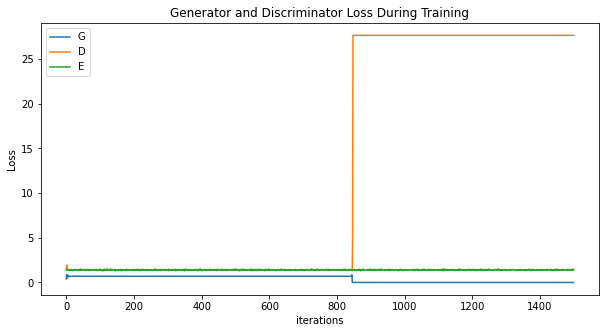

In [13]:
plot_train_loss()

---

# Test Data

In [54]:
#test_data_root = "../../dataset/test/test_DualPhaseSteel"
Ti64_test_data_root = "../../dataset/test/test_Ti64"

test_data_set = dataset.ImageFolder(root = Ti64_test_data_root, # test_data_root,
                           transform = transforms.Compose([
                                  transforms.Resize(img_size),
                                  transforms.CenterCrop(img_size),
                                  torchvision.transforms.Grayscale(channel),
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.5,),(0.5,))
                              ]))

# 배치로 나누고 셔플하기
test_data_loader = torch.utils.data.DataLoader(test_data_set, batch_size = 1,
                                              shuffle = False, num_workers = workers)

# 이상 픽셀 수 확인 함수

In [55]:
def count_el_not_0(diff_img):
    count_el_not_0 = 0
    
    col_size = diff_img.shape[0]
    row_size = diff_img.shape[1]
    
    #print(col_size, row_size)
    
    for col in range(col_size):
        for row in range(row_size):
            if diff_img[col][row] != 0:
                count_el_not_0 += 1
                
    return count_el_not_0

# img 비교 함수

In [56]:
def compare_imgs(real_img, generated_img, i, score, reverse=False, threshold=50):
    real_img = real_img.cpu().data.numpy().reshape(img_size, img_size) * 255
    generated_img = generated_img.cpu().data.numpy().reshape(img_size, img_size) * 255
    
    negative = np.zeros_like(real_img)

    if not reverse:
        diff_img = real_img - generated_img
    else:
        diff_img = generated_img - real_img

    diff_img[diff_img <= threshold] = 0

    # 분율 추출
    diff_cnts.append(count_el_not_0(diff_img))
    # 분산 추출
    diff_points.append(np.where(diff_img > threshold))
    
    anomaly_img = np.zeros(shape=(img_size, img_size, 3))
    anomaly_img[:, :, 0] = real_img - diff_img
    anomaly_img[:, :, 1] = real_img - diff_img
    anomaly_img[:, :, 2] = real_img - diff_img
    anomaly_img[:, :, 0] = anomaly_img[:,:,0] + diff_img
    anomaly_img = anomaly_img.astype(np.uint8)

    # anomaly_img 추출
    anomaly_imgs.append(anomaly_img)
    
    fig, plots = plt.subplots(1, 4)

    fig.suptitle(f'Anomaly - (anomaly score: {score:.4})')
    
    fig.set_figwidth(9)
    fig.set_tight_layout(True)
    plots = plots.reshape(-1)
    plots[0].imshow(real_img, cmap='gray', label = "real")
    plots[1].imshow(generated_img, cmap='gray')
    plots[2].imshow(diff_img, cmap='gray')
    plots[3].imshow(anomaly_img)
    
    plots[0].set_title('real')
    plots[1].set_title('generated')
    plots[2].set_title('difference')
    plots[3].set_title('Anomaly Detection')
    plt.show()

# Test

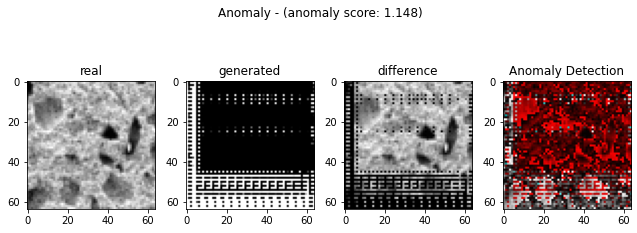

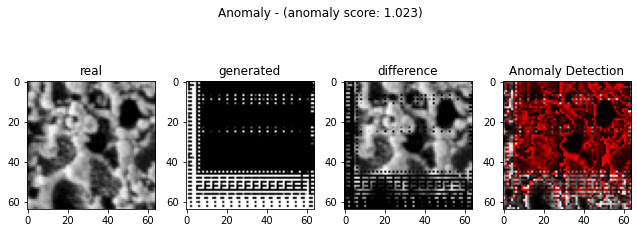

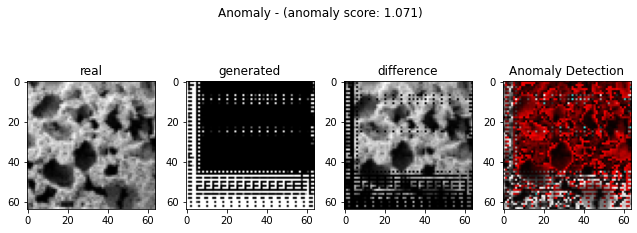

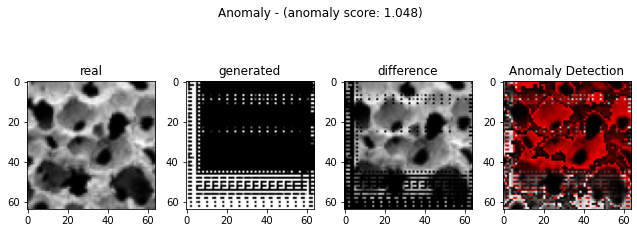

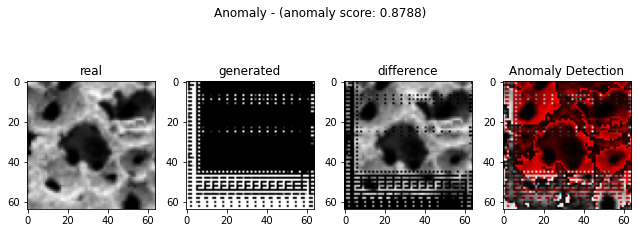

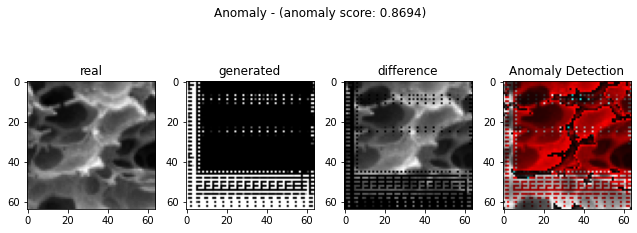

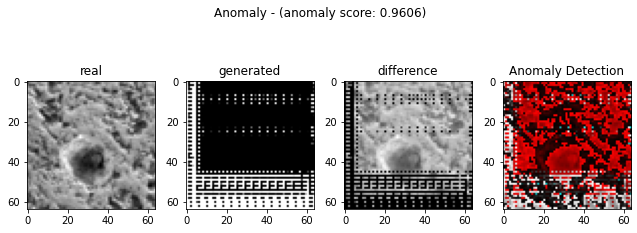

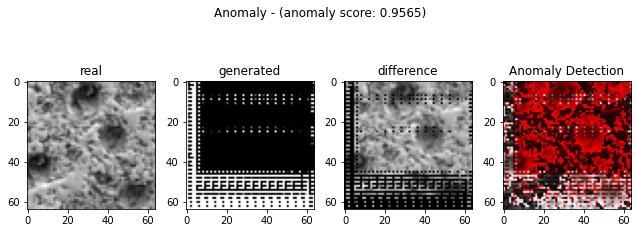

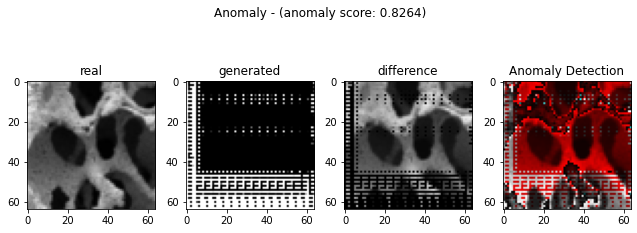

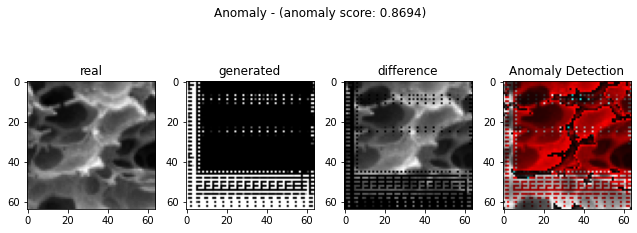

In [57]:
diff_cnts = []
diff_points = []
anomaly_imgs = []

ano_criterion = nn.MSELoss()
DC.eval()
D.eval()
EC.eval()

# with open("score.csv", "w") as f:
#         f.write("label,img_distance,anomaly_score,z_distance\n")

for i, data in enumerate(test_data_loader, 0):
    real_img = data[0].to(device)

    real_z = EC(real_img) # 진짜 이미지의 latent vector
    fake_img = DC(real_z) # DC에 넣어서 가짜 이미지 생성.
    fake_z = EC(fake_img) # torch.Size([1, 100]) --> latent 진짜 이미지와 매핑된 가짜 이미지의 latent vector

    _, real_feature = D.forward(real_img) # 1, 256
    _, fake_feature = D.forward(fake_img)

    img_distance = ano_criterion(fake_img, real_img)
    loss_feature = ano_criterion(fake_feature, real_feature)

    anomaly_score = img_distance + kappa*loss_feature

    z_distance = ano_criterion(fake_z, real_z)
    
#     with open("score.csv", "a") as f:
#             f.write(f"{label.item()},{img_distance},"
#                     f"{anomaly_score},{z_distance}\n")
            
#     print(f"{label.item()}, {img_distance}, "
#           f"{anomaly_score}, {z_distance}\n")
    compare_imgs(real_img, fake_img, i, anomaly_score, reverse = False, threshold = 0.3)

---

# 분율 추출

In [58]:
diff_cnts = np.array(diff_cnts)

diff_fraction = diff_cnts / img_size ** 2

print(diff_fraction)

[0.75366211 0.73242188 0.75097656 0.7175293  0.73217773 0.75048828
 0.75390625 0.75244141 0.74926758 0.75048828]


In [59]:
sum(diff_fraction)/len(diff_fraction)

0.7443359375

---

# 분산 추출

In [60]:
from scipy import stats
from extended_int import int_inf

corr_coeffis = []
corr_p_vals = []

def cal_corr_coeffis():
    for idx in range(len(test_data_loader)):
        x_points = diff_points[idx][0]
        y_points = diff_points[idx][1]
        
        
        if len(x_points) > 0:
            corr_coeffi, corr_p_val = stats.pearsonr(x_points, y_points)
        else:
            corr_coeffi, corr_p_val = -int_inf, -int_inf
        
        corr_coeffis.append(corr_coeffi)
        corr_p_vals.append(corr_p_val)

In [61]:
cal_corr_coeffis()

print(corr_coeffis)

[0.0022450394789672264, 0.018691412861550523, 0.008166757321544241, 0.02239364326376682, -0.0036097565385667884, 0.0035721300668050283, 0.003528863162137132, 0.004768874034500073, 0.006742441348497553, 0.0035721300668050283]


---

# 모델 저장 및 읽기

In [62]:
save_file = "./pretrained/pretrained.pth"

def save_pretrained():
    pretrained = {
        "D" : D.state_dict(),
        "DC" : DC.state_dict(),
        "EC" : EC.state_dict()
    }

    if not os.path.isdir("pretrained"):
        os.mkdir("pretrained")
    torch.save(pretrained, save_file)

In [63]:
save_pretrained()

In [64]:
pretrained_D = Discriminator().to(device)
pretrained_DC = Decoder().to(device)
pretrained_EC = Encoder().to(device)

def load_pretrained():
    global pretrained_D
    global pretrained_DC
    global pretrained_EC
    
    assert os.path.isdir("pretrained"), "Error : no pretrained dir found!"
    
    pretrained = torch.load(save_file)
    
    pretrained_D.load_state_dict(pretrained["D"])
    pretrained_DC.load_state_dict(pretrained["DC"])
    pretrained_EC.load_state_dict(pretrained["EC"])
    
    #print("pretrained_D :", pretrained_D)
    #print("pretrained_G :", pretrained_DC)
    #print("pretrained_E :", pretrained_EC)

In [65]:
load_pretrained()

In [66]:
def test():
    ano_criterion = nn.MSELoss()
    pretrained_DC.eval()
    pretrained_D.eval()
    pretrained_EC.eval()

    # with open("score.csv", "w") as f:
    #         f.write("label,img_distance,anomaly_score,z_distance\n")

    for i, data in enumerate(test_data_loader, 0):
        real_img = data[0].to(device)

        real_z = pretrained_EC(real_img) # 진짜 이미지의 latent vector
        fake_img = pretrained_DC(real_z) # DC에 넣어서 가짜 이미지 생성.
        fake_z = pretrained_EC(fake_img) # torch.Size([1, 100]) --> latent 진짜 이미지와 매핑된 가짜 이미지의 latent vector

        _, real_feature = pretrained_D.forward(real_img) # 1, 256
        _, fake_feature = pretrained_D.forward(fake_img)

        img_distance = ano_criterion(fake_img, real_img)
        loss_feature = ano_criterion(fake_feature, real_feature)

        anomaly_score = img_distance + kappa*loss_feature

        z_distance = ano_criterion(fake_z, real_z)

    #     with open("score.csv", "a") as f:
    #             f.write(f"{label.item()},{img_distance},"
    #                     f"{anomaly_score},{z_distance}\n")

    #     print(f"{label.item()}, {img_distance}, "
    #           f"{anomaly_score}, {z_distance}\n")
        compare_imgs(real_img, fake_img, i, anomaly_score, reverse = False, threshold = 0.3)

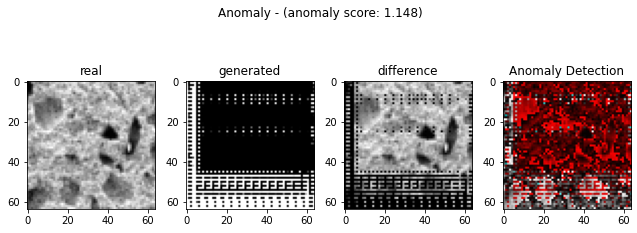

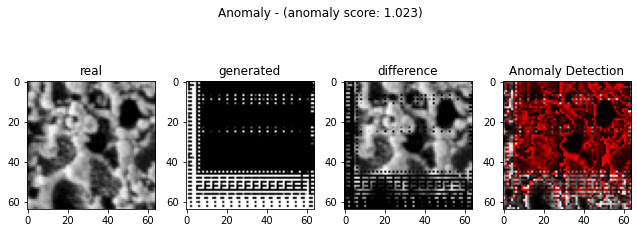

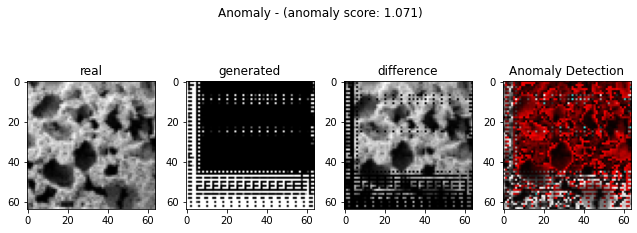

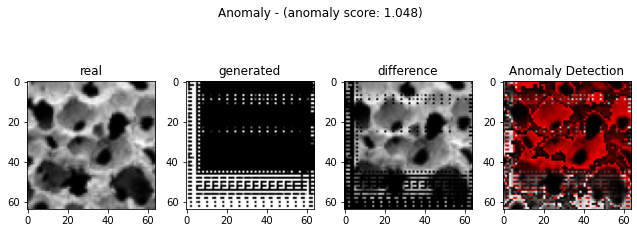

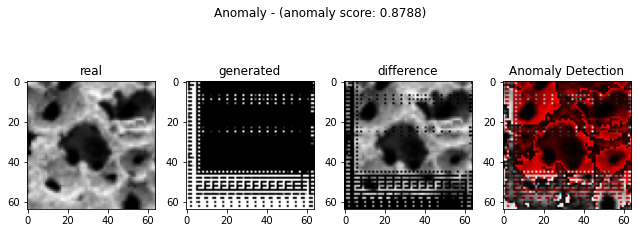

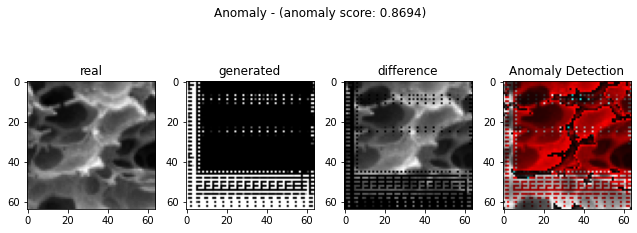

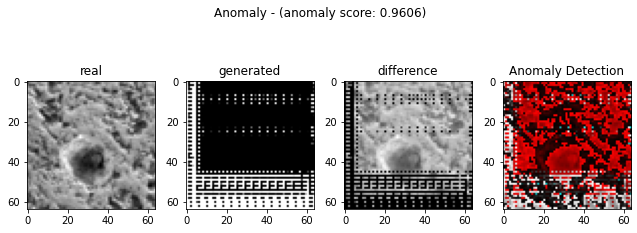

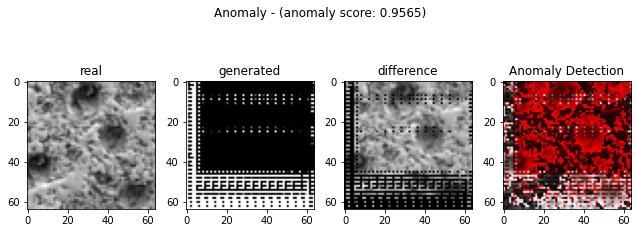

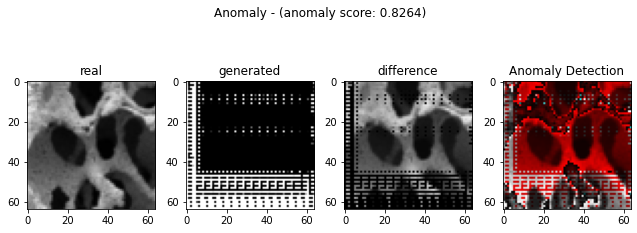

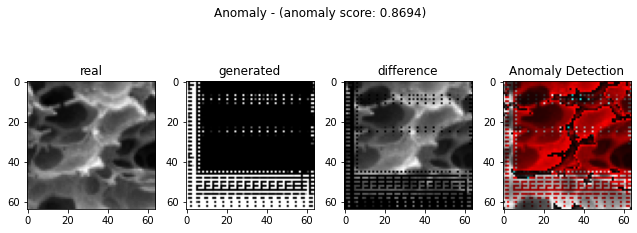

In [67]:
diff_cnts = []
diff_points = []
anomaly_imgs = []

corr_coeffis = []
corr_p_vals = []

test()

In [68]:
diff_cnts = np.array(diff_cnts)

diff_fraction = diff_cnts / img_size ** 2

print(diff_fraction)

[0.75366211 0.73242188 0.75097656 0.7175293  0.73217773 0.75048828
 0.75390625 0.75244141 0.74926758 0.75048828]


In [69]:
cal_corr_coeffis()

print(corr_coeffis)

[0.0022450394789672264, 0.018691412861550523, 0.008166757321544241, 0.02239364326376682, -0.0036097565385667884, 0.0035721300668050283, 0.003528863162137132, 0.004768874034500073, 0.006742441348497553, 0.0035721300668050283]


---

# anomaly detection 이미지 추출

In [70]:
anomaly_imgs

[array([[[ 15,  15,  15],
         [185,   1,   1],
         [113,   1,   1],
         ...,
         [ 51,   2,   2],
         [117,   1,   1],
         [111,   2,   2]],
 
        [[  5,   5,   5],
         [ 35,   2,   2],
         [204, 204, 204],
         ...,
         [ 49,   2,   2],
         [ 61,   2,   2],
         [ 53,  53,  53]],
 
        [[  7,   7,   7],
         [  9,   1,   1],
         [ 57,   1,   1],
         ...,
         [191,   1,   1],
         [237,   1,   1],
         [ 75,   1,   1]],
 
        ...,
 
        [[113, 113, 113],
         [158, 158, 158],
         [184, 184, 184],
         ...,
         [ 55,  55,  55],
         [ 45,  45,  45],
         [ 53,  53,  53]],
 
        [[132, 132, 132],
         [176, 176, 176],
         [201,   1,   1],
         ...,
         [245,   1,   1],
         [ 17,   2,   2],
         [ 41,  41,  41]],
 
        [[121, 121, 121],
         [178, 178, 178],
         [134, 134, 134],
         ...,
         [162, 162, 162],
  

# 이미지 저장 함수

In [71]:
import cv2

def save_imgs(folder, imgs):
    if not os.path.isdir("anomaly_imgs"):
        os.mkdir("anomaly_imgs")
    
    for i in range(len(imgs)):
        cv2.imwrite('%s/%d.png' %(folder,i), imgs[i]) #이미지 저장할 경로 설정을 여기서 한다.
    print("image saving complete")

In [72]:
save_imgs("./anomaly_imgs", anomaly_imgs)

image saving complete


---

# 티타늄(Ti64) 상대 밀도 계산

In [73]:
Ti64_density = 4.43

Ti64_rel_densitys = np.array([])

Ti64_rel_densitys = diff_fraction * Ti64_density

print(Ti64_rel_densitys)

[3.33872314 3.24462891 3.32682617 3.17865479 3.24354736 3.32466309
 3.33980469 3.33331543 3.31925537 3.32466309]


# 티타늄(Ti64) 기공도 계산

In [74]:
Ti64_pore_rate = 1 - diff_fraction

In [75]:
Ti64_pore_rate

array([0.24633789, 0.26757812, 0.24902344, 0.2824707 , 0.26782227,
       0.24951172, 0.24609375, 0.24755859, 0.25073242, 0.24951172])